# **Identificación de Imágenes Auténticas y Sintéticas : Abordando los Desafíos de las Imágenes Sintéticas en la Sociedad Actual**

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Creación del Modelo](#title3)

## Configuración del Entorno<a name="title1"></a>

In [1]:
import tensorflow as tf
print(tf.config.experimental.list_physical_devices("GPU"))
print(tf.__version__)
# Para limitar la memoria que usa la GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar TensorFlow para que solo utilice la GPU si es necesario
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuración de GPU completada")
    except RuntimeError as e:
        print(e)
# Verifica que la GPU está disponible
print("¿GPU está disponible?:", tf.config.list_physical_devices('GPU'))
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import gc
import tensorflow as tf
from keras import backend as K

# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.10.0
Configuración de GPU completada
¿GPU está disponible?: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


0

In [2]:
# Limpiar la memoria del backend
K.clear_session()
# Forzar la recolección de basura
gc.collect()

105

In [3]:
# Importar todas las librerías de uso.
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()


## Construcción del Conjunto de Datos y Preprocesandolos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/kaustubhdhote/human-faces-dataset & https://www.kaggle.com/datasets/hamzaboulahia/hardfakevsrealfaces/code

In [5]:

# Parámetros
batch_size = 32
img_height = 224 
img_width = 224
initial_epochs = 10
fine_tune_epochs = 10

# Directorio de datos
data_folder = './Data/All'

# Cargar el dataset completo
full_dataset = image_dataset_from_directory(
    data_folder,
    image_size=(img_height, img_width),
    batch_size=None,  # Cargar todas las imágenes individualmente
    shuffle=True,
    seed=123  # Semilla para reproducibilidad
)

# Obtener el tamaño total del dataset
dataset_size = full_dataset.cardinality().numpy()

# Definir tamaños para entrenamiento, validación y prueba
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

# Dividir el dataset
train_dataset = full_dataset.take(train_size)
remaining = full_dataset.skip(train_size)
validation_dataset = remaining.take(val_size)
test_dataset = remaining.skip(val_size)

# Agrupar los datasets
train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Capturar class_names
class_names = full_dataset.class_names
print("Clases:", class_names)

# Aplicar prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 10919 files belonging to 2 classes.
Clases: ['Fake', 'Real']


In [12]:
# Autoencoder
input_img = layers.Input(shape=(img_height, img_width, 3))
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)  # (112, 112, 64)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # (56, 56, 128)

# Decodificar para ajuste con ResNet50
decoded = layers.Conv2D(3, (1, 1), activation='relu', padding='same')(encoded)  # Reducir canales a 3
decoded = layers.UpSampling2D((4, 4))(decoded)  # Escalar de (56, 56) a (224, 224, 3)

# Modelo Autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# Codificador ajustado para ResNet50
encoder = Model(input_img, decoded)

# Usar el codificador ajustado
encoded_inputs = encoder(input_img)

# Preprocesamiento
x = preprocess_input(encoded_inputs)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 3)         387 

# Modelo<a name="title3"></a>



In [13]:
# Modelo base ResNet50
base_model = ResNet50(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Capas superiores del clasificador
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.005))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Modelo completo
model_resnet = Model(input_img, outputs)
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])
model_resnet.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 model_6 (Functional)        (None, 224, 224, 3)       76035     
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                           

In [14]:
# Pesos de clase
y_train = np.concatenate([y for x, y in train_dataset], axis=0)
class_weights_values = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights_values))

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Entrenamiento
history_resnet = model_resnet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# Fine-Tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
                     loss='binary_crossentropy', 
                     metrics=['accuracy'])

history_fine_resnet = model_resnet.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history_resnet.epoch[-1],
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
239/239 [==============================] - 55s 216ms/step - loss: 2.0172 - accuracy: 0.8760 - val_loss: 1.4250 - val_accuracy: 0.9493 - lr: 1.0000e-04
Epoch 2/10
239/239 [==============================] - 48s 199ms/step - loss: 1.1725 - accuracy: 0.9494 - val_loss: 0.9449 - val_accuracy: 0.9585 - lr: 1.0000e-04
Epoch 3/10
239/239 [==============================] - 48s 200ms/step - loss: 0.8249 - accuracy: 0.9563 - val_loss: 0.7017 - val_accuracy: 0.9609 - lr: 1.0000e-04
Epoch 4/10
239/239 [==============================] - 48s 199ms/step - loss: 0.6290 - accuracy: 0.9622 - val_loss: 0.5321 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 5/10
239/239 [==============================] - 48s 200ms/step - loss: 0.5142 - accuracy: 0.9655 - val_loss: 0.4471 - val_accuracy: 0.9719 - lr: 1.0000e-04
Epoch 6/10
239/239 [==============================] - 48s 199ms/step - loss: 0.4295 - accuracy: 0.9687 - val_loss: 0.3754 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 7/10
239/239 [========

52/52 [==============================] - 7s 70ms/step
Umbral Óptimo: 1.0


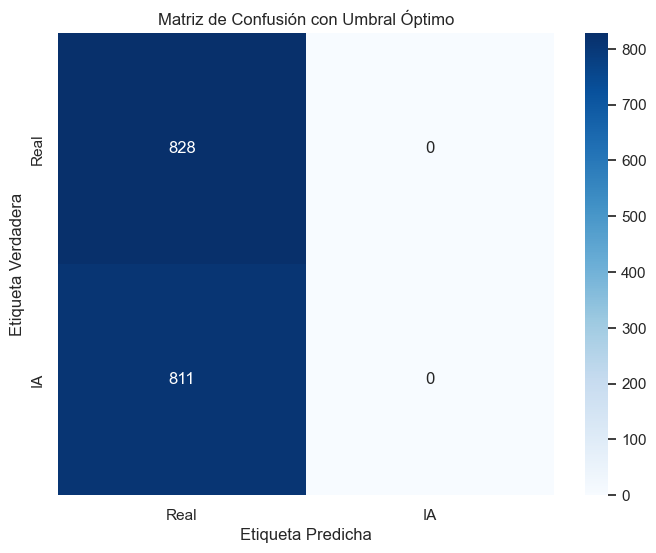


Reporte de Clasificación con Umbral Óptimo:
              precision    recall  f1-score   support

        Real       0.51      1.00      0.67       828
          IA       0.00      0.00      0.00       811

    accuracy                           0.51      1639
   macro avg       0.25      0.50      0.34      1639
weighted avg       0.26      0.51      0.34      1639

Precisión Global con Umbral Óptimo: 0.5051860890787065


c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\isidr\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [15]:
# Métricas
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)
predictions_resnet = model_resnet.predict(test_dataset).ravel()

# Ajustar el umbral óptimo
fpr, tpr, thresholds = roc_curve(true_labels, predictions_resnet)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Umbral Óptimo: {optimal_threshold}")

# Aplicar el umbral óptimo
predicted_labels_optimal = (predictions_resnet > optimal_threshold).astype(int)

# Matriz de Confusión con umbral óptimo
conf_matrix = confusion_matrix(true_labels, predicted_labels_optimal)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'IA'],
            yticklabels=['Real', 'IA'])
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión con Umbral Óptimo')
plt.show()

# Reporte de Clasificación con umbral óptimo
print("\nReporte de Clasificación con Umbral Óptimo:")
print(classification_report(true_labels, predicted_labels_optimal, target_names=['Real', 'IA']))

# Precisión Global con umbral óptimo
accuracy_optimal = accuracy_score(true_labels, predicted_labels_optimal)
print(f"Precisión Global con Umbral Óptimo: {accuracy_optimal}")

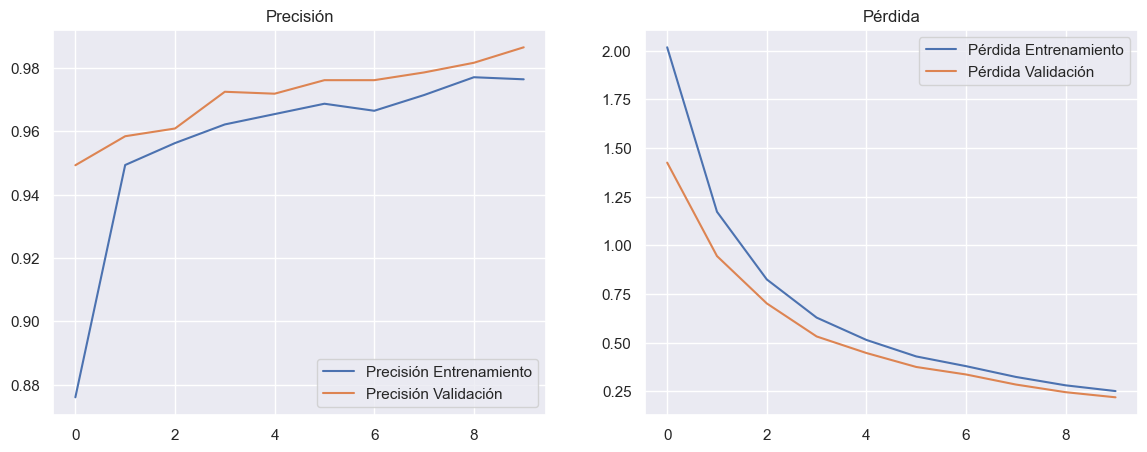

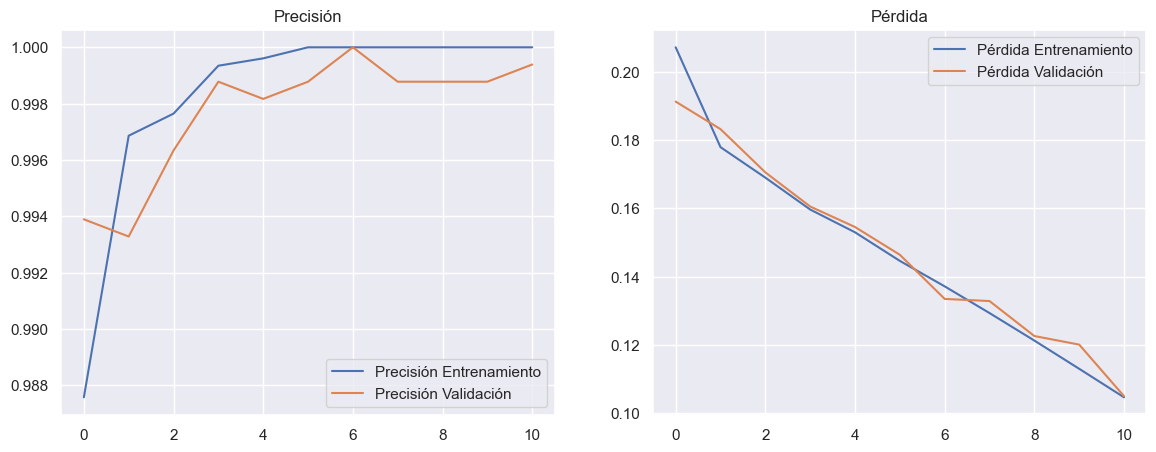

In [16]:
# Gráficas de métricas
def plot_metrics(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 5))
    
    # Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Precisión Validación')
    plt.legend(loc='lower right')
    plt.title('Precisión')
    
    # Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Pérdida Validación')
    plt.legend(loc='upper right')
    plt.title('Pérdida')
    
    plt.show()

# Gráficas para el entrenamiento inicial
plot_metrics(history_resnet)

# Gráficas para el fine-tuning
plot_metrics(history_fine_resnet)
